In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [ ]:
# Path to the images
image_path = "../../../../Thomson Lab Dropbox/David Larios/activedrops/calibration_curve/*ugml.tif"

# Get list of image files
image_files = sorted(glob.glob(image_path))[1:]

# Initialize lists to store protein concentrations and mean intensities
protein_concentrations_nM = []
mean_intensities = []

# Define a colormap
colormap = plt.cm.get_cmap('tab10', len(image_files))

# Display images in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for ax, image_file in zip(axes, image_files):
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    
    # Extract protein concentration from the file name and convert to nanomolar
    protein_concentration_ugml = float(image_file.split('/')[-1].split('ugml')[0])
    protein_concentration_nM = protein_concentration_ugml * 1E-3 / 27000  # Convert to M
    protein_concentration_nM = protein_concentration_nM * 1E9  # Convert to nM
    protein_concentrations_nM.append(protein_concentration_nM)
    
    # Create a mask for the image
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Use the mask to remove the background
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    ax.imshow(masked_img, cmap='gray')
    ax.axis('off')
    
    # Calculate mean intensity
    mean_intensity = np.mean(masked_img[mask == 255])
    mean_intensities.append(mean_intensity)

plt.tight_layout()
plt.show()

# Plot histogram of pixel intensity for all images, excluding masked pixels
plt.figure(figsize=(10, 5))
plt.title("Histogram of Pixel Intensity for All Images (Masked)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

for idx, image_file in enumerate(image_files):
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    masked_img = img[mask == 255]
    hist = cv2.calcHist([masked_img], [0], None, [256], [0, 256])
    plt.plot(hist, alpha=0.5, color=colormap(idx), label=image_file.split('/')[-1].replace('.tif', ''))

plt.xlim([0, 30])
plt.legend()
plt.show()

# Plot the mean intensities
plt.figure(figsize=(10, 5))
for idx, (protein_concentration_nM, mean_intensity) in enumerate(zip(protein_concentrations_nM, mean_intensities)):
    plt.plot(protein_concentration_nM, mean_intensity, marker='o', color=colormap(idx), label=image_files[idx].split('/')[-1].replace('.tif', ''))
plt.title("Mean Intensity of Each Image")
plt.xlabel("Protein Concentration (nM)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Convert lists to numpy arrays for linear regression
protein_concentrations_nM = np.array(protein_concentrations_nM).reshape(-1, 1)
mean_intensities = np.array(mean_intensities)

# Perform linear regression
reg = LinearRegression().fit(protein_concentrations_nM, mean_intensities)
slope = reg.coef_[0]
intercept = reg.intercept_

# Calculate R-squared
r_squared = r2_score(mean_intensities, reg.predict(protein_concentrations_nM))

# Print the linear regression equation and R-squared value
print(f"Linear Regression Equation: Mean Intensity = {slope:.4f} * Protein Concentration (nM) + {intercept:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Plot the linear regression result
plt.figure(figsize=(10, 5))
plt.scatter(protein_concentrations_nM, mean_intensities, color='blue', label='Data Points')
plt.plot(protein_concentrations_nM, reg.predict(protein_concentrations_nM), color='red', 
         label=f'Linear Fit: y = {slope:.4f}x + {intercept:.4f}, $R^2$ = {r_squared:.4f}')
plt.title("Linear Regression of Mean Intensity vs Protein Concentration")
plt.xlabel("Protein Concentration (nM)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.legend()
plt.show()




In [ ]:
import cv2
import numpy as np
import pandas as pd
import glob

# Path to the images
path = "../../../../Thomson Lab Dropbox/David Larios/activedrops/main/101324-k401-titration-rt/2p5TMB-1ulDNA_/K401_160nM-RT/Rep1/original/"
gfp_files = sorted([file for file in glob.glob(f"{path}*") if 'gfp' in file.lower()])[::10]

# List to store mean intensities
mean_intensities = []

# Define the codec and create VideoWriter object
frame_height, frame_width = cv2.imread(gfp_files[0], cv2.IMREAD_GRAYSCALE).shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('../../../../Downloads/thresholded_timelapse.avi', fourcc, 1, (frame_width, frame_height), isColor=False)

# Process each image
for file in gfp_files:
    # Read the image
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image is loaded
    if img is None:
        print(f"Failed to read image: {file}")
        continue
    
    # Apply Otsu's thresholding
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Mask the image
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    # Write the frame to the video
    out.write(masked_img)
    
    # Calculate mean intensity of the masked image
    mean_intensity = cv2.mean(masked_img, mask=mask)[0]
    mean_intensities.append(mean_intensity)

# Release the video writer
out.release()

# Create a DataFrame
df = pd.DataFrame({
    'Image': gfp_files,
    'Mean Intensity': mean_intensities
}).reset_index()

# Display the DataFrame
df


In [ ]:
df['time (s)'] = df['index'] * 600

# Add time in minutes and hours
df['time (min)'] = df['time (s)'] / 60
df['time (h)'] = df['time (s)'] / 3600

df['Concentration (nM)'] = (df['Mean Intensity'] - intercept) / slope

df

In [ ]:
import matplotlib.pyplot as plt

# Plot concentration vs time (h)
plt.figure(figsize=(10, 5))
plt.plot(df['time (h)'], df['Mean Intensity'], marker='o', linestyle='-')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (nM)')
plt.title('Concentration vs Time (hours)')
plt.grid(True)
plt.show()


All that thing doesn't work very well because the thresholding messes up the
ploots. Let's just focus on a 1mm x 1mm square at the center of the image.

That worked better!

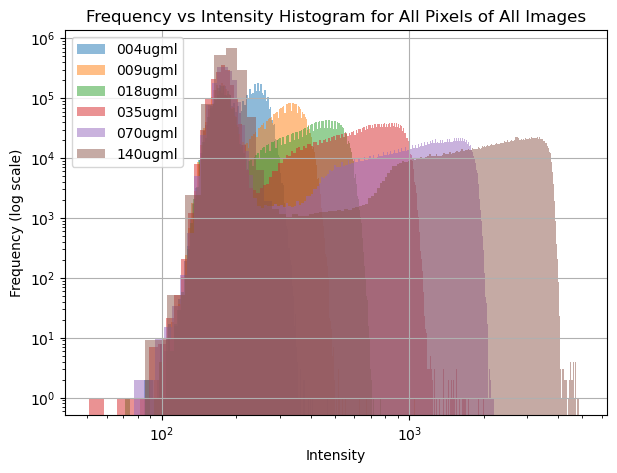

,Filename,Mean Intensity,Concentration (µg/ml),Concentration (nM)
0,004ugml,252.044709,4.0,148.148148
1,009ugml,348.024606,9.0,333.333333
2,018ugml,488.546442,18.0,666.666667
3,035ugml,818.732813,35.0,1296.296296
4,070ugml,1479.622917,70.0,2592.592593
5,140ugml,2941.739781,140.0,5185.185185


In [44]:
# Import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd

# Path to the images
image_path = "../../../../Thomson Lab Dropbox/David Larios/activedrops/calibration_curve/*ugml.tif"

# Get list of image files
image_files = sorted(glob.glob(image_path))[::]

protein_concentrations_ugml = []
protein_concentrations_nM = []
mean_intensities = []
filenames = []

# Chunk 1: Generate frequency vs intensity histogram for all pixels of all images
plt.figure(figsize=(7, 5))
for image_file in image_files:
    img = io.imread(image_file)

    # Extract protein concentration from the file name
    protein_concentration_ugml = float(image_file.split('/')[-1].split('ugml')[0])
    protein_concentration_nM = protein_concentration_ugml * 1E-3 / 27000 * 1E9  # Convert to nM
    protein_concentrations_ugml.append(protein_concentration_ugml)
    protein_concentrations_nM.append(protein_concentration_nM)

    # Calculate mean intensity using only the pixels within a 730 pixel radius circle at the center of the image
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    y, x = np.ogrid[:img.shape[0], :img.shape[1]]
    mask = (x - center_x)**2 + (y - center_y)**2 <= 730**2
    cropped_img = img[mask]
    mean_intensity = np.mean(cropped_img)
    mean_intensities.append(mean_intensity)
    
    # Extract filename without path and .tif extension
    filename = image_file.split('/')[-1].replace('.tif', '')
    filenames.append(filename)
    
    # Use all pixels for histogram
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=image_file.split('/')[-1].replace('.tif', ''))

plt.yscale('log')  # Set y-axis to log scale
plt.xscale('log')  # Set y-axis to log scale

plt.title('Frequency vs Intensity Histogram for All Pixels of All Images')
plt.xlabel('Intensity')
# plt.xlim([0, 1000])
plt.ylabel('Frequency (log scale)')
plt.legend(loc='upper left')
plt.grid(True)

# Save the plot as an SVG file
plt.savefig("../../../../Downloads/frequency_vs_intensity_histogram.svg", format='svg', dpi=500)

plt.show()

# Chunk 3: Create a DataFrame with filename, mean intensity, concentration in µg/ml, and concentration in nM
df_mean_intensity = pd.DataFrame({
    'Filename': filenames,
    'Mean Intensity': mean_intensities,
    'Concentration (µg/ml)': protein_concentrations_ugml,
    'Concentration (nM)': protein_concentrations_nM
})

# Display the DataFrame
df_mean_intensity


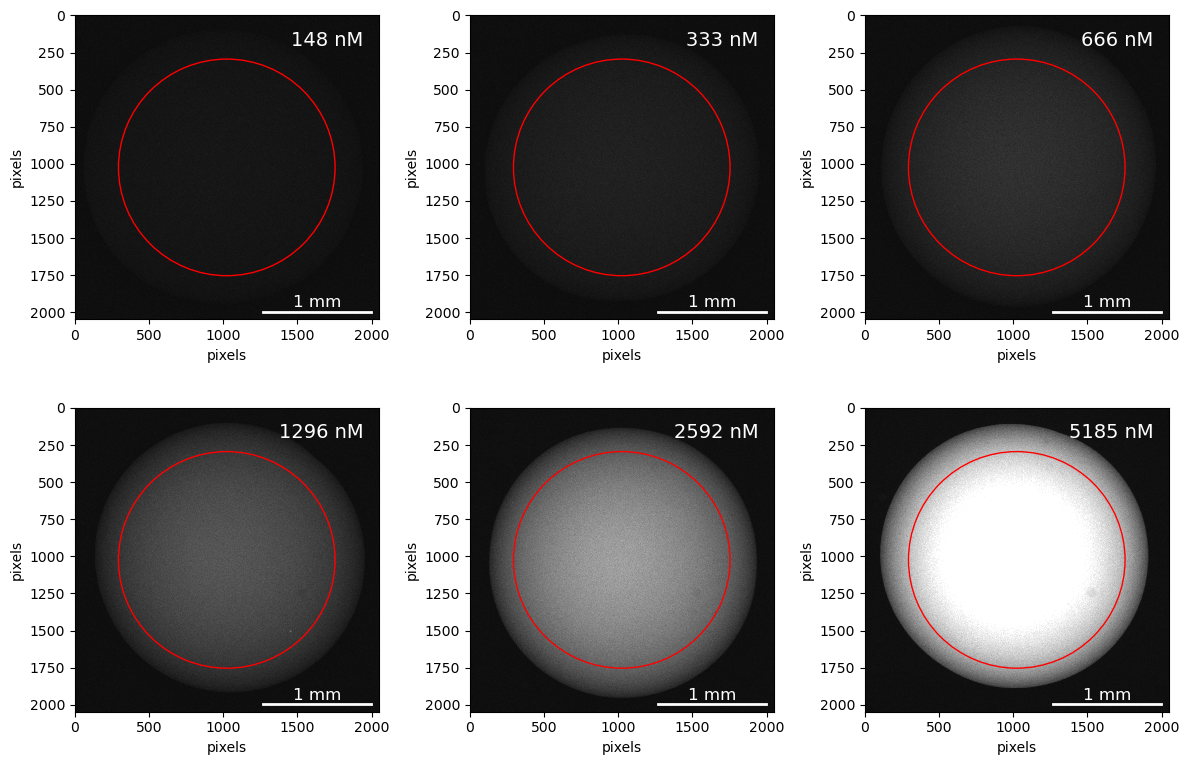

In [45]:
# Chunk 2: Display images in a 3x3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjusted figsize to reduce column separation
axes = axes.flatten()

for ax, image_file in zip(axes, image_files):
    img = io.imread(image_file)
    
    # Display the image
    ax.imshow(img, cmap='gray', interpolation='nearest', vmin=0, vmax=3000)
    
    # Draw a 730 pixel radius circle in red at the very center of the image
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    circle = plt.Circle((center_x, center_y), 730, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(circle)
    
    # Extract protein concentration in nM from the filename
    protein_concentration_ugml = float(image_file.split('/')[-1].split('ugml')[0])
    protein_concentration_nM = int(protein_concentration_ugml * 1E-3 / 27000 * 1E9)  # Convert to nM and round to integer
    
    # Add concentration in nM as text in the top right corner
    ax.text(0.95, 0.95, f"{protein_concentration_nM} nM", color='white', fontsize=14, ha='right', va='top', transform=ax.transAxes)
     
    # Add a scale bar in the bottom right side, slightly up
    ax.plot([img.shape[1] - 780, img.shape[1] - 50], [img.shape[0] - 50, img.shape[0] - 50], color='white', linewidth=2)
    ax.text(img.shape[1] - 415, img.shape[0] - 60, '1 mm', color='white', fontsize=12, ha='center', va='bottom')
    
    # Add axes labels
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')

plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("../../../../Downloads/image_grid.svg", format='svg', dpi=500)

plt.show()

Linear Regression Equation: Mean Intensity = 0.5337 * Protein Concentration (nM) + 145.4342
R-squared: 0.9990


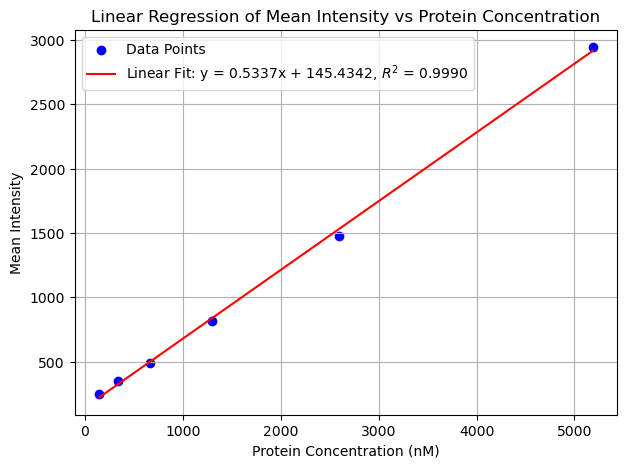

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
# Perform linear regression
protein_concentrations_nM = df_mean_intensity['Concentration (nM)'].values.reshape(-1, 1)
mean_intensities = df_mean_intensity['Mean Intensity'].values

reg = LinearRegression().fit(protein_concentrations_nM, mean_intensities)
slope = reg.coef_[0]
intercept = reg.intercept_

# Calculate R-squared
r_squared = r2_score(mean_intensities, reg.predict(protein_concentrations_nM))

# Print the linear regression equation and R-squared value
print(f"Linear Regression Equation: Mean Intensity = {slope:.4f} * Protein Concentration (nM) + {intercept:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Plot the linear regression result
plt.figure(figsize=(7, 5))
plt.scatter(protein_concentrations_nM, mean_intensities, color='blue', label='Data Points')
plt.plot(protein_concentrations_nM, reg.predict(protein_concentrations_nM), color='red', 
         label=f'Linear Fit: y = {slope:.4f}x + {intercept:.4f}, $R^2$ = {r_squared:.4f}')
plt.title("Linear Regression of Mean Intensity vs Protein Concentration")
plt.xlabel("Protein Concentration (nM)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.legend()

# Save the plot as an SVG file
plt.savefig("../../../../Downloads/linear_regression_result.svg", format='svg', dpi=500)

plt.show()

In [4]:
df_mean_intensity['Predicted Concentration (nM)'] = (df_mean_intensity['Mean Intensity'] - intercept) / slope
df_mean_intensity['Error (%)'] = ((df_mean_intensity['Concentration (nM)'] - df_mean_intensity['Predicted Concentration (nM)']) / df_mean_intensity['Concentration (nM)']) * 100
df_mean_intensity

,Filename,Mean Intensity,Concentration (µg/ml),Concentration (nM),Predicted Concentration (nM),Error (%)
0,004ugml,252.044709,4.0,148.148148,199.738908,-34.823763
1,009ugml,348.024606,9.0,333.333333,379.560889,-13.868267
2,018ugml,488.546442,18.0,666.666667,642.833881,3.574918
3,035ugml,818.732813,35.0,1296.296296,1261.450577,2.688098
4,070ugml,1479.622917,70.0,2592.592593,2499.653268,3.584803
5,140ugml,2941.739781,140.0,5185.185185,5238.984700,-1.037562


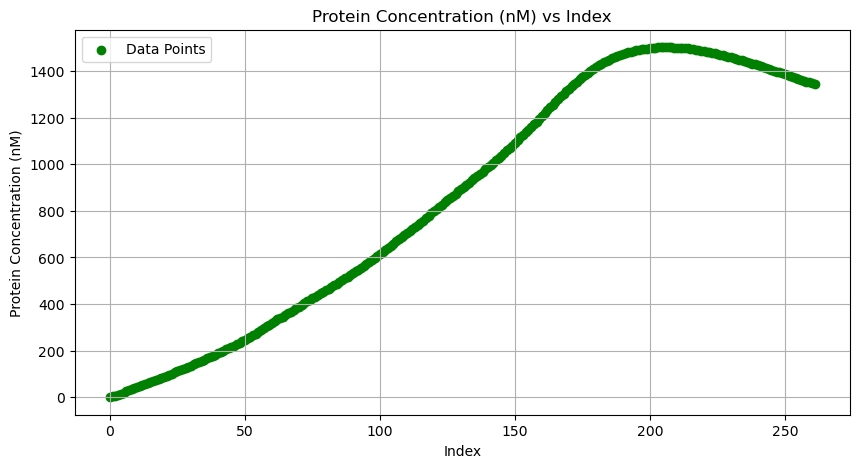

In [11]:
from skimage import io
import numpy as np

# Path to the images
path = "../../../../Thomson Lab Dropbox/David Larios/activedrops/main/101324-k401-titration-rt/2p5TMB-1ulDNA_/K401_160nM-RT/Rep1/original/"
gfp_files = sorted([file for file in glob.glob(f"{path}*") if 'gfp' in file.lower()])[::10]

# Read the images and calculate the mean intensity in a 730 pixel radius circle at the center
mean_intensities = []
radius = 730
for file in gfp_files:
    image = io.imread(file)
    # Determine the center of the image
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    # Create a mask for the circle
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
    # Extract the circular region
    center_circle = image[mask]
    # Calculate the mean intensity of the center circle
    mean_intensity = np.mean(center_circle)
    mean_intensities.append(mean_intensity)

# Store the mean intensities in a DataFrame
df = pd.DataFrame({
    'Filename': gfp_files,
    'Mean Intensity': mean_intensities
})

# Use the slope and intercept from the calibration curve to calculate protein concentration in nM
df['Protein Concentration (nM)'] = (df['Mean Intensity'] - intercept) / slope

# Subtract the minimum protein concentration from all protein concentrations
df['Protein Concentration (nM)'] = df['Protein Concentration (nM)'] - df['Protein Concentration (nM)'].min()

# Display the DataFrame
df.reset_index()

plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['Protein Concentration (nM)'], color='green', label='Data Points')
plt.title("Protein Concentration (nM) vs Index")
plt.xlabel("Index")
plt.ylabel("Protein Concentration (nM)")
plt.grid(True)
plt.legend()
plt.show()


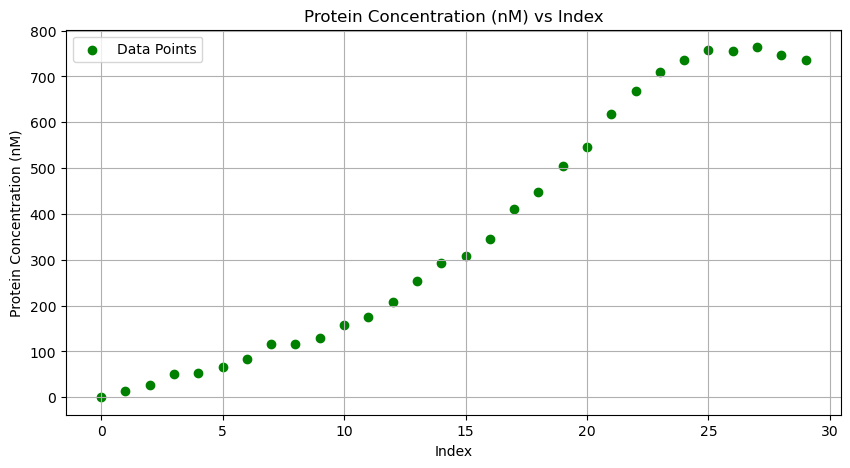

In [7]:
from skimage import io

# Path to the images
path = "../../../../Thomson Lab Dropbox/David Larios/activedrops/main/111624-C-E-G-RT/2p5ulTMB-0p5MT-1ulDNA_/G_160nM/Rep1/original/"
gfp_files = sorted([file for file in glob.glob(f"{path}*") if 'gfp' in file.lower()])[::50]

# Read the images and calculate the mean intensity in a 1000x1000 square at the center
mean_intensities = []
for file in gfp_files:
    image = io.imread(file)
    # Determine the center of the image
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    # Extract the 1000x1000 square at the center
    center_square = image[center_y - 500:center_y + 500, center_x - 500:center_x + 500]
    # Calculate the mean intensity of the center square
    mean_intensity = np.mean(center_square)
    mean_intensities.append(mean_intensity)

# Store the mean intensities in a DataFrame
df = pd.DataFrame({
    'Filename': gfp_files,
    'Mean Intensity': mean_intensities
})

# Use the slope and intercept from the calibration curve to calculate protein concentration in nM
df['Protein Concentration (nM)'] = (df['Mean Intensity'] - intercept) / slope

# Subtract the minimum protein concentration from all protein concentrations
df['Protein Concentration (nM)'] = df['Protein Concentration (nM)'] - df['Protein Concentration (nM)'].min()

# Display the DataFrame
df.reset_index()

plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['Protein Concentration (nM)'], color='green', label='Data Points')
plt.title("Protein Concentration (nM) vs Index")
plt.xlabel("Index")
plt.ylabel("Protein Concentration (nM)")
plt.grid(True)
plt.legend()
plt.show()
